# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

**Assignment**
Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
   * Excel and Vensim are only supported on Windows
   * Vensim requires the DSS version of Vensim
   * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get [NetLogo 6.3.0](https://ccl.northwestern.edu/netlogo/download.shtml)
   * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
   * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).


|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes [example scripts](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples) for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel).
  * This [tutorial](https://emaworkbench.readthedocs.io/en/latest/basic_tutorial.html) also shows a simple model in Python, Vensim and Excel connected to the workbench.

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function.

In [1]:
# Some imports you may need
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.samplers import LHSSampler
from ema_workbench.em_framework.salib_samplers import MorrisSampler, SobolSampler

from ema_workbench.analysis.plotting import lines, Density

from ema_workbench import SequentialEvaluator, MultiprocessingEvaluator


C:\Users\marno\.conda\envs\EPA1361\Lib\site-packages\ema_workbench\connectors\__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
C:\Users\marno\.conda\envs\EPA1361\Lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)
C:\Users\marno\.conda\envs\EPA1361\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


In [2]:
# Import the Python function
from model.pred_prey import PredPrey

In [3]:
# Define uncertainties and outcomes
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)]

outcomes = [#TimeSeriesOutcome('TIME'),
                 TimeSeriesOutcome('predators'),
                 TimeSeriesOutcome('prey')]

# Define model objects for the different implementations

# python
model_py = Model('PredPreyPY', function = PredPrey)

# system dynamics
mdl_file = "./model/PredPrey.mdl"
model_sd = PysdModel('PredPreySD', mdl_file = mdl_file)

# netlogo
wd = "./model"
f = "PredPrey.nlogo"
model_nl = NetLogoModel('PredPreyNL', wd=wd, model_file=f)

experiments, results = {}, {}

for model in [model_py, model_sd]:#, model_nl]:
    model.uncertainties, model.outcomes = uncertainties, outcomes
    print('Running {}...'.format(model.name))
    if isinstance(model, NetLogoModel):
        with SequentialEvaluator(model) as evaluator:
            experiments[model.name], results[model.name] = evaluator.perform_experiments(scenarios=50, policies=0)
    else:
        with MultiprocessingEvaluator(model) as evaluator:
            experiments[model.name], results[model.name] = evaluator.perform_experiments(scenarios=50, policies=0)
        

Running PredPreyPY...


100%|██████████████████████████████████████████| 50/50 [00:05<00:00,  9.02it/s]


Running PredPreySD...


100%|██████████████████████████████████████████| 50/50 [00:27<00:00,  1.83it/s]


PredPreyPY


AttributeError: 'NoneType' object has no attribute 'T'

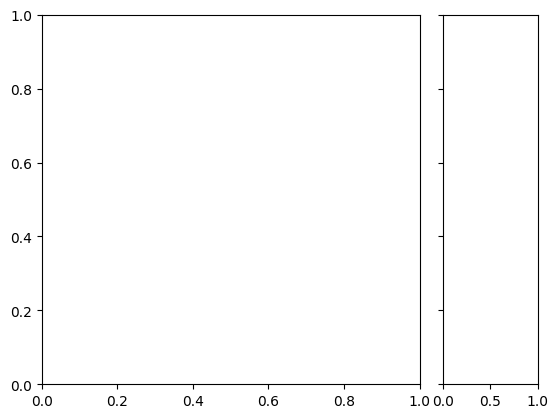

In [5]:
for model_type in experiments.keys():
    print(model_type)
    exp = experiments[model_type]
    res = results[model_type]
    for result in res.keys():
        lines(exp, res, outcomes_to_show=result,
                       density=Density.HIST)
plt.show()